In [1]:
import os
import time
import inspect

import tensorflow as tf
import numpy as np
from scipy.io import loadmat

import skimage
import skimage.io
import skimage.transform

import warnings
warnings.filterwarnings('ignore')

import scipy
import matplotlib.pyplot as plt
plt.ion()

In [83]:
class VggFace2:
    def __init__(self, vggFace2_mat_path=None):
        self.mean_pixel = np.array([131.0912,  103.8827,   91.4953])
        
#         if vggFace2_mat_path is None:
#             path = inspect.getfile(VggFace2)
#             path = os.path.abspath(os.path.join(path, os.pardir))
#             path = os.path.join(path, "./matconvnet/senet/senet50_ft-dag.mat")
#             vggFace2_mat_path = path
#             print(vggFace2_mat_path)

#         print("mat file loading...")
        data = loadmat("./matconvnet/senet/senet50_ft-dag.mat")
        
#         print("make data_dict...")
        self.data_dict = {}
        for idx in range(len(data['params'][0])):
            param_name = data['params'][0][idx][0][0]
            param_value = data['params'][0][idx][1]
            self.data_dict[param_name] = param_value
        
#         print("make layer info...")
        self.layer_info = {}
        self.layers = data['layers'][0]
        for idx in range(len(data['layers'][0])):
            per_layer_info = {}
            
            layer_name = self.layers[idx]['name'][0]
            layer_type = self.layers[idx]['type'][0]
            input_name = self.layers[idx][2][0][0][0]
            output_name = self.layers[idx][3][0][0][0]            
            params_names = []
            if len(self.layers[idx][4]) > 0:
                for i in range(len(self.layers[idx][4][0])):
                    params_names.append(self.layers[idx][4][0][i][0])
            meta_info = {}
            if self.layers[idx][5] == None:
                meta_info = {None}
            else:
                for meta_info_name in self.layers[idx][5].dtype.names:
                    if meta_info_name in ['numChannels', 'opts']:
                        meta_info[meta_info_name] = self.layers[idx][5][meta_info_name][0][0]
                    elif meta_info_name in ['pad', 'dilate', 'size', 'stride', 'method', 'poolSize', 'shape']:
                        meta_info[meta_info_name] = self.layers[idx][5][meta_info_name][0][0][0]
                    elif meta_info_name in ['epsilon', 'hasBias', 'useShortCircuit', 'leak']:
                        meta_info[meta_info_name] = self.layers[idx][5][meta_info_name][0][0][0][0]
                    else:
                        meta_info[meta_info_name] = self.layers[idx][5][meta_info_name][0][0][0][0][0]
            per_layer_info['name'] = layer_name
            per_layer_info['type'] = layer_type
            per_layer_info['input_name'] = input_name
            per_layer_info['output_name'] = output_name
            per_layer_info['params'] = params_names
            per_layer_info['meta'] = meta_info
            self.layer_info[layer_name] = per_layer_info

#     def _undo():
#         out_for_print = out + np.array([131.0912,  103.8827,   91.4953])
#         out_for_print = out_for_print/255.0

    def build(self, input_image, isImageNormalized=True):
        """
        :param input_image: rgb image [batch, height, width, 3] values scaled [0,1] - when use skimage
        """
        start_time = time.time()
        print("build model started...")
        if isImageNormalized:
            input_image = input_image * 255.0
        
        input_image = input_image - self.mean_pixel
        
        if not (input_image.get_shape().as_list()[1:] == [224, 224, 3]):
            input_image = tf.image.resize_bicubic(input_image, [224, 224])

        current = input_image
        for idx, layer in enumerate(self.layers):
            name = self.layers['name'][idx][0]
            layer_type = self.layers['type'][idx][0]
            if layer_type == 'dagnn.Conv':
                current = self.conv_layer(current, name)
            elif layer_type == 'dagnn.BatchNorm':
                current = self.batch_normalization_layer(current, name)
            elif layer_type == 'dagnn.ReLU':
                current = tf.nn.relu(current)
            elif layer_type == 'dagnn.Pooling':
                current = self.pooling_layer(current, name)
                break
#                 print(self.layer_info[name]['params'])
#                 print(self.layer_info[name]['meta']['pad'])
#                 print(self.layer_info[name]['meta']['size'])
#             if name[:4] == 'conv':
#                 print(self.layer_info[name]['meta'])
        return current

    def pooling_layer(self, bottom, name):
        with tf.variable_scope(name):
            method = self.layer_info[name]['meta']['method']
            if method == 'max':
                padded_input = tf.pad(bottom, [[0, 0], [0, 1], [0, 1], [0, 0]], "CONSTANT")
                return tf.nn.max_pool(padded_input, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID', name=name)
            else: # 'avg'
                return tf.nn.avg_pool(bottom, ksize=[1, 7, 7, 1], strides=[1, 1, 1, 1], padding='VALID', name=name)
                
    # sigma(k) = sqrt(sigma2(k) + EPSILON)
    def batch_normalization_layer(self, bottom, name):
        with tf.variable_scope(name):
            bn_mult = np.squeeze(self.data_dict[name + '_mult'])
            bn_bias = np.squeeze(self.data_dict[name + '_bias'])
            bn_mu = self.data_dict[name + '_moments'][:, 0]
            bn_sigma = self.data_dict[name + '_moments'][:, 1]
            return tf.nn.batch_normalization(bottom, bn_mu, (tf.square(bn_sigma)-1e-5), bn_bias, bn_mult, 1e-5, name=name)
            
    def conv_layer(self, bottom, name):
        with tf.variable_scope(name):
            kernel = self.get_conv_kernel(name)
            bias = self.get_conv_bias(name)
            stride = self.get_conv_stride(name)
            
            conv = tf.nn.conv2d(bottom, kernel, stride, padding='SAME')
            return tf.nn.bias_add(conv, bias)

    def get_conv_kernel(self, name):
        # matconvnet: kernels are [width, height, in_channels, out_channels]
        # tensorflow: kernels are [height, width, in_channels, out_channels]
        kernel = self.data_dict[name + '_filter']
        kernel = np.transpose(kernel, (1, 0, 2, 3))
        
        return tf.constant(kernel, name="kernels")

    def get_conv_stride(self, name):
        s = self.layer_info[name]['meta']['stride'][0]
#         print("stride: ", [1, s, s, 1])
        return [1, s, s, 1]
        
    def get_conv_bias(self, name):
        if self.layer_info[name]['meta']['hasBias']:
            return tf.constant(self.data_dict[name + '_bias'], name="bias")
        else:
            bias_size = self.layer_info[name]['meta']['size'][3]
            return tf.zeros([bias_size], tf.float32, name="bias")

        #all padding is "SAME"
#     def get_conv_pad(self, name):
#         return self.layer_info[name]['meta']['pad']

In [3]:
def load_image(path):
    # load image
    img = skimage.io.imread(path)
    # print "Original Image Shape: ", img.shape
    # we crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    # resize to 224, 224
    resized_img = skimage.transform.resize(crop_img, (128, 128))
    return resized_img

In [4]:
img1 = load_image("./data/61237.jpg")
img1 = img1.reshape((1, 128, 128, 3))

# img2 = load_image("./data/62607.jpg")
# img2 = img2.reshape((1, 128, 128, 3))

# batch = np.concatenate((img1, img2), 0)

In [81]:
with tf.Session() as sess:
    image = tf.placeholder("float", [1, 128, 128, 3])
    feed_dict = {image: img1}
    
    vggFace2 = VggFace2()
    vggFace2_out = vggFace2.build(image)
    out = sess.run(vggFace2_out, feed_dict=feed_dict)

build model started...
here


In [84]:
out.shape

(1, 56, 56, 64)

In [61]:
out.shape

(1, 112, 112, 64)

In [85]:
out

array([[[[  1.07548571e+00,   4.31341410e-01,   1.38468170e+00, ...,
            1.02378273e+00,   2.18598986e+00,   1.89947057e+00],
         [  6.42519236e-01,   4.84647870e-01,   1.40372527e+00, ...,
            1.01275265e+00,   8.87552381e-01,   1.18410695e+00],
         [  6.72443151e-01,   5.18694162e-01,   1.40084183e+00, ...,
            9.85560477e-01,   8.62509429e-01,   1.13173604e+00],
         ..., 
         [  9.69268084e-01,   6.34849548e-01,   1.46301234e+00, ...,
            1.06290269e+00,   1.16183054e+00,   1.15459418e+00],
         [  9.60565329e-01,   6.07866168e-01,   1.45852602e+00, ...,
            1.07158399e+00,   1.09197557e+00,   1.10823345e+00],
         [  4.22911882e-01,   0.00000000e+00,   1.45253634e+00, ...,
            9.67682004e-01,   2.54061431e-01,   7.34573030e+00]],

        [[  1.04349184e+00,   4.31341410e-01,   1.47221661e+00, ...,
            8.66121888e-01,   2.17057085e+00,   1.47645783e+00],
         [  6.51092529e-01,   4.84647870e-01,

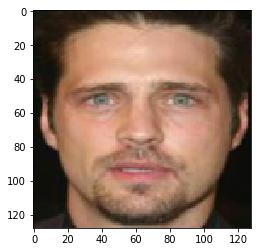

In [10]:
# out_for_print = out + np.array([131.0912,  103.8827,   91.4953])
# out_for_print = out_for_print/255.0

plt.imshow(scipy.misc.toimage(np.squeeze(img1)))

In [71]:
# custom padding test
# matconvnet: max pooling 'pad':  [TOP BOTTOM LEFT RIGHT]  [0, 1, 0, 1]
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [1, 3, 3, 1])
    # 2: height, 1: width
    padded_input = tf.pad(input_, [[0, 0], [0, 1], [0, 1], [0, 0]], "CONSTANT")
    
    num = np.arange(9).reshape((1, 3, 3, 1))
    
    feed_dict = {input_:num}
    out = sess.run(padded_input, feed_dict=feed_dict)